## Edinburgh AirBnB
#### Author: Clare Watts

Data:
* Recent data from: http://insideairbnb.com/get-the-data.html
* 2019 data from: https://www.kaggle.com/thoroc/edinburgh-inside-airbnb?select=calendar.csv

Goals:
1. Ascertain the effect of the Fringe Festival on the prices of AirBnB lets in Edinburgh
2. Find other features related to price
3. Try to predict the price of a listing based on details about the property

# Business Understanding (a brief description of the problem and questions of interest)
Airbnb data on price of lets and details of lets is availabe via Inside Airbnb. <br>
The problem: Is it possible to ascertain what is a fair price for a room given its location, and details of the property and room. In addition, what factors strongly influence the price, and what is the effect specifically of the Fringe Festival in August?

## 1. Perform setup and get data
### 1.1 Start Spark session

In [1]:
#in the location this code is stored must be a folder called helpers 
#and in it the spark.py file needs to be stored
from helpers.spark import getSpark
spark=getSpark()

#Import the Java type - Equivilent to the Python "import" statement
sc = spark.sparkContext
SparkHelper = sc._gateway.jvm.com.rbs.edh.spark.utils.SparkHelper

#Get the Spark user to determine the home area
user = SparkHelper.getSparkUser()
username = user
password = SparkHelper.Security.getFromHadoopKeyStore(f"/user/{user}/keystore.jceks",f"{user}.pwd")

### 1.2 Import libraries and functions

In [2]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from matplotlib import style

# Data Understanding (Access and Explore)
Data is available as csv files. These need to be read in and cleaned/explored. <br>
The below section acheives this in the following stages:
* Import data
* Merge together the data from different .csv files - it can be seen that the calendar files cover short periods of data of advertised prices into the future. There are overlaps in the files, so this will need to be handled to merge the datsets together into one dataset
* Once this is done (see Data Prep and Cleaning) data can begin to be visualised

### 1.3 Read in data

In [3]:
## Calendar data spanning availability on AirBnB website plus an earlier year:
calendardf1 = pd.read_csv('./calendar20210308.csv')
calendardf2 = pd.read_csv('./calendar20210211.csv')
calendardf3 = pd.read_csv('./calendar20200427.csv')
calendardf4 = pd.read_csv('./calendar2019.csv')

calendardf1['compiled_date'] = '2021-03-08'
calendardf2['compiled_date'] = '2021-02-11'
calendardf3['compiled_date'] = '2020-04-27'
calendardf4['compiled_date'] = '2019'

In [4]:
## Check data
dfnames = ['calendardf1', 'calendardf2', 'calendardf3', 'calendardf4']
dfs = [calendardf1, calendardf2, calendardf3, calendardf4]
for i in range(len(dfnames)):
    print(dfnames[i], 'first date =', dfs[i]['date'].min(), 'last date =', dfs[i]['date'].max())

calendardf1 first date = 2021-03-08 last date = 2022-03-31
calendardf2 first date = 2021-02-11 last date = 2022-02-18
calendardf3 first date = 2020-04-27 last date = 2021-04-28
calendardf4 first date = 2019-06-25 last date = 2020-06-24


# Data Preparation (Cleaning)
* In order to have the most up to date information, order the merged data by compiled date and pick the most recent values.
* For ease of manipulation set the dates as index and order.
* Can see that price data contains non-numeric characters - these need to be removed in order to be able to cast this column as a numeric data type (required for calculating mean)
* Similar story for listings data, which can be ordered by last_scraped column to merge and take most recent data
* Although lots of Nulls are found at this stage in the listings data, since I will be aggregating the data later on they are kept and the nulls will be re-evaluated after aggregation

## Discussion on categorical variables
* From listings data, the columns neighbourhood, property type and room type are hypothesised to be important in determining price. These are non-numeric variables and need to be handled as categorical.
* These are handled using the pd.get_dummies method, to produce new columns of each unique value for each categorical variable in the dataset.
* After aggregation there are no nulls in the dataset so a separate dummy for this does not need to be created, and no nulls need to be dropped or filled in.
    * Note that in the section comparing change in fringe period with percent change in price NaN values are dropped - but these are the first row of data, which are necessarily Null when the change in a value from week to week is computed.
* The advantage of this approach in this project is that because I am using linear modles, it order allows for each value for each category to be fitted with its own coefficient, so that strong relationships can be picked out.
* The disadvantage of this method is that it produces a lot of columns, and this must be monitored in order to ensure that the number of columns does not exceed around 10% of the number of observations.

### 1.4 Clean data

#### 1.4.1 Calendar data

In [5]:
## Dates to datetime:------------------------------------------------------------------------------------

for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    df['compiled_date'] = pd.to_datetime(df['compiled_date'])

## Stitch together:--------------------------------------------------------------------------------------
## Choose to use most up to date information
calendardf = pd.concat([calendardf1, calendardf2, calendardf3, calendardf4]).sort_values('compiled_date', ascending=False).drop_duplicates(subset=['listing_id', 'date'], keep='first')

## Check for duplicates not dropped:---------------------------------------------------------------------
checkdf = calendardf.groupby(['listing_id', 'date'])['available'].count()
checkdf[checkdf>1]


Series([], Name: available, dtype: int64)

In [6]:
## view any duplicates:
# calendardf.loc[(calendardf['listing_id']==54188) & (calendardf['date'] >= '2021-06-17')].sort_values('date').head(10) 

In [7]:
## Set date as index:------------------------------------------------------------------------------------
calendardf = calendardf.set_index('date').sort_index()
calendardf.head(10)

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,compiled_date
date,,,,,,,
2019-06-25,15064168,f,$80.00,$80.00,2.0,7.0,2019-01-01
2019-06-25,30013151,f,$85.00,$85.00,2.0,1125.0,2019-01-01
2019-06-25,19609630,f,$100.00,$90.00,2.0,360.0,2019-01-01
2019-06-25,34245374,f,$30.00,$30.00,2.0,1125.0,2019-01-01
2019-06-25,27634495,f,$35.00,$35.00,7.0,20.0,2019-01-01
2019-06-25,18390477,f,$60.00,$60.00,2.0,1125.0,2019-01-01
2019-06-25,20545644,f,$71.00,$71.00,1.0,1125.0,2019-01-01
2019-06-25,3798955,f,$50.00,$50.00,2.0,1125.0,2019-01-01
2019-06-25,19128105,f,$80.00,$80.00,1.0,1125.0,2019-01-01


In [8]:
## Only need one pricing variable - drop adjusted_price:
calendardf.drop('adjusted_price', axis=1, inplace=True)
calendardf.head(10)

,listing_id,available,price,minimum_nights,maximum_nights,compiled_date
date,,,,,,
2019-06-25,15064168,f,$80.00,2.0,7.0,2019-01-01
2019-06-25,30013151,f,$85.00,2.0,1125.0,2019-01-01
2019-06-25,19609630,f,$100.00,2.0,360.0,2019-01-01
2019-06-25,34245374,f,$30.00,2.0,1125.0,2019-01-01
2019-06-25,27634495,f,$35.00,7.0,20.0,2019-01-01
2019-06-25,18390477,f,$60.00,2.0,1125.0,2019-01-01
2019-06-25,20545644,f,$71.00,1.0,1125.0,2019-01-01
2019-06-25,3798955,f,$50.00,2.0,1125.0,2019-01-01
2019-06-25,19128105,f,$80.00,1.0,1125.0,2019-01-01


In [9]:
# calendardf.info(0)

In [10]:
# calendardf.isnull().sum()

In [11]:
## Clean price columns:----------------------------------------------------------------------------------
## Need to clean up price column to remove $
calendardf['price'] = [pd.to_numeric(i.replace('$', '').replace(',', '')) for i in calendardf['price']]

calendardf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11133932 entries, 2019-06-25 to 2022-03-31
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   available       object        
 2   price           float64       
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   compiled_date   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 594.6+ MB


In [12]:
calendardf.head(5)

,listing_id,available,price,minimum_nights,maximum_nights,compiled_date
date,,,,,,
2019-06-25,15064168,f,80.0,2.0,7.0,2019-01-01
2019-06-25,30013151,f,85.0,2.0,1125.0,2019-01-01
2019-06-25,19609630,f,100.0,2.0,360.0,2019-01-01
2019-06-25,34245374,f,30.0,2.0,1125.0,2019-01-01
2019-06-25,27634495,f,35.0,7.0,20.0,2019-01-01


2019-06-25 00:00:00 2022-03-31 00:00:00


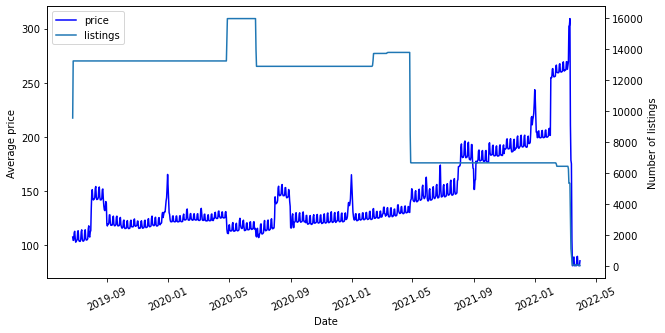

In [15]:
## plot
print(calendardf.index[0], calendardf.index[-1])

fig, ax = plt.subplots(figsize=(10,5))

to_plot = calendardf.groupby(calendardf.index)['price'].mean()
ax.plot(to_plot, 'b-', label='price')
plt.xticks(rotation=25)
ax.set_xlabel("Date")
ax.set_ylabel('Average price')

ax2 = ax.twinx()
to_plot = calendardf.groupby(calendardf.index)['listing_id'].count()
ax2.plot(to_plot, label='listings')
ax2.set_ylabel('Number of listings')

lines = ax.get_lines() + ax2.get_lines()
ax2.legend(lines, [line.get_label() for line in lines], loc='upper left')


We can see that the first two years of data look similar, whereas 2021 looks very different. This data is for the future (rather than historic), and of course COVID and lock-down will have had a large impact.
Perhaps 2021 is different due to the easing of lockdown within the UK resulting in an increase in demand and an increase in price?
Looking at the number of listings we can see that has also changed dramatically at the same time - perhaps the average price has increased as more and more people take their properties off the site, and only the properties which are buy-to-lets are left (whole property lets which are more expensive)?

In [16]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Text(0.5, 1.0, 'Average rental price of Airbnb lets in Edinburgh')

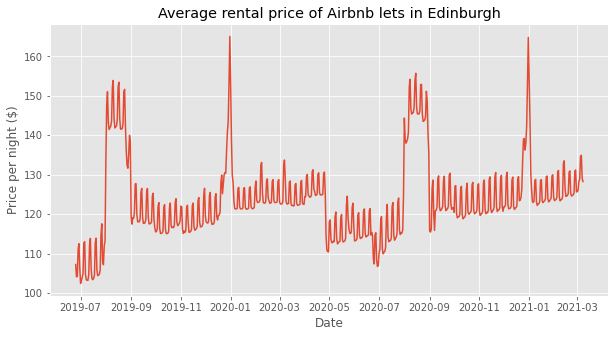

In [17]:
# print(plt.style.available)
plt.style.use('ggplot') #'seaborn-muted'

## Plot just 2019-20 price data:
fig, ax = plt.subplots(figsize=(10,5))

## For historical data only:
to_plot = calendardf[calendardf.index <= '2021-03-08'].groupby(calendardf[calendardf.index <= '2021-03-08'].index)['price'].mean();
## For whole time frame:
# to_plot = calendardf.groupby(calendardf.index)['price'].mean();
ax.plot(to_plot)
ax.set_xlabel("Date")
ax.set_ylabel('Price per night ($)')
ax.set_title('Average rental price of Airbnb lets in Edinburgh')

#### 1.4.2 Listings data

In [18]:
## Listings data spanning availability on AirBnB website:
listingsdf1 = pd.read_csv('./listings20210308.csv')
listingsdf2 = pd.read_csv('./listings20210211.csv')
listingsdf3 = pd.read_csv('./listings20200427.csv')
listingsdf4 = pd.read_csv('./listings2019.csv')

c:\dev\.conda\envs\jupyter-lab\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
## Check data
dfnames = ['listingsdf1', 'listingsdf2', 'listingsdf3', 'listingsdf4']
dfs = [listingsdf1, listingsdf2, listingsdf3, listingsdf4]
for i in range(len(dfnames)):
    print(dfnames[i], '1st scrape date =', dfs[i]['last_scraped'].min(), 'last scrape date =', dfs[i]['last_scraped'].max())

listingsdf1 1st scrape date = 2021-03-08 last scrape date = 2021-04-01
listingsdf2 1st scrape date = 2021-02-11 last scrape date = 2021-02-19
listingsdf3 1st scrape date = 2020-04-27 last scrape date = 2020-04-29
listingsdf4 1st scrape date = 2019-06-25 last scrape date = 2019-06-26


In [20]:
## Dates to datetime:------------------------------------------------------------------------------------

for df in dfs:
    df['last_scraped'] = pd.to_datetime(df['last_scraped'])

## Large table - take only columns of immediate interest common to all data files for a basic model:
cols = ['id', 'listing_url', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'neighbourhood',
        'neighbourhood_cleansed', 'property_type', 'room_type', 'last_scraped']
# for i in range(len(dfnames)):
#     dfs[i] = dfs[i][cols].sort_values('last_scraped')
# #     print(dfs[i].columns)
listingsdf1 = listingsdf1[cols].sort_values('last_scraped')
listingsdf2 = listingsdf2[cols].sort_values('last_scraped')
listingsdf3 = listingsdf3[cols].sort_values('last_scraped')
listingsdf4 = listingsdf4[cols].sort_values('last_scraped')

## Stitch together:--------------------------------------------------------------------------------------
## Choose to use most up to date information
listingsdf = pd.concat([listingsdf1, listingsdf2, listingsdf3, listingsdf4]).drop_duplicates(subset=['id', 'listing_url'], keep='first')

## Check for duplicates not dropped:---------------------------------------------------------------------
checkdf = listingsdf.groupby(['id', 'listing_url'])['accommodates'].count()
checkdf[checkdf>1]

Series([], Name: accommodates, dtype: int64)

In [21]:
listingsdf.head(5)

,id,listing_url,accommodates,bathrooms,bedrooms,beds,neighbourhood,neighbourhood_cleansed,property_type,room_type,last_scraped
4661,35356200,https://www.airbnb.com/rooms/35356200,4,NaN,2.0,2.0,NaN,"Old Town, Princes Street and Leith Street",Entire apartment,Entire home/apt,2021-03-08
6176,45913129,https://www.airbnb.com/rooms/45913129,4,NaN,2.0,2.0,"Edinburgh, Scotland, United Kingdom","Old Town, Princes Street and Leith Street",Entire apartment,Entire home/apt,2021-03-08
4596,34997914,https://www.airbnb.com/rooms/34997914,4,NaN,2.0,2.0,"Edinburgh, Scotland, United Kingdom","Old Town, Princes Street and Leith Street",Entire townhouse,Entire home/apt,2021-03-08
4584,34959773,https://www.airbnb.com/rooms/34959773,6,NaN,4.0,4.0,"Edinburgh, Scotland, United Kingdom",Gorgie West,Entire apartment,Entire home/apt,2021-03-08
4581,34935631,https://www.airbnb.com/rooms/34935631,2,NaN,1.0,2.0,"Edinburgh, Scotland, United Kingdom",Broughton South,Private room in house,Private room,2021-03-08


In [22]:
listingsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16756 entries, 4661 to 13244
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      16756 non-null  int64         
 1   listing_url             16756 non-null  object        
 2   accommodates            16756 non-null  int64         
 3   bathrooms               10099 non-null  float64       
 4   bedrooms                16542 non-null  float64       
 5   beds                    16684 non-null  float64       
 6   neighbourhood           13238 non-null  object        
 7   neighbourhood_cleansed  16756 non-null  object        
 8   property_type           16756 non-null  object        
 9   room_type               16756 non-null  object        
 10  last_scraped            16756 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 1.5+ MB


In [23]:
listingsdf.isnull().sum()
## quite a few nulls in bathrooms, but perhaps once aggregated to listings this will not be the case

id                           0
listing_url                  0
accommodates                 0
bathrooms                 6657
bedrooms                   214
beds                        72
neighbourhood             3518
neighbourhood_cleansed       0
property_type                0
room_type                    0
last_scraped                 0
dtype: int64

# Modelling (Optional)
* Before modelling some descriptive analysis is done looking at correlations of features (including a feature describing the Fringe Festival period in August) with the price of lets.
* Subsequently two approaches to modelling are used - ordinary least squares and Ridge regression

## 2. Question 1: What is the effect of the Fringe on price?
What is the uplift in price for rentals during the fringe?
What is the effect of Hogmany? To make the most money, which one should you rent for?

### 2.1 Prepare calendar data

In [24]:
## Take only historical data, since as shown above the more recent pricing data seems odd:
calendardf = calendardf[calendardf.index <= '2021-05-01']

## Group by to get average prices as a function of time:
calendar_ave = calendardf.groupby(calendardf.index)['price','minimum_nights','maximum_nights'].mean()
# calendar_ave.head()

c:\dev\.conda\envs\jupyter-lab\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [25]:
## Add dummy variable to indicate Fringe period:
fringe_period2019 =  pd.date_range(start='08/01/2019', end='08/31/2019')
fringe_period2020 =  pd.date_range(start='08/01/2020', end='08/31/2020')


fringe_period = fringe_period2019.append(fringe_period2020)
fringe_period
calendar_ave['fringe_period'] = (calendar_ave.index.isin(fringe_period)) * 1
# calendar_ave.head()
# calendar_ave[calendar_ave['fringe_period'] ==1]

### 2.2 Create time-stationarised variables for correlation check

In [26]:
## Stationarise using .diff():

diff_calendar_ave = calendar_ave.diff()
diff_calendar_ave.head()

## Look at perentage change for target variable only:

diff_calendar_ave['price'] = calendar_ave['price'].pct_change()
diff_calendar_ave.head()


,price,minimum_nights,maximum_nights,fringe_period
date,,,,
2019-06-25,NaN,NaN,NaN,NaN
2019-06-26,-0.029099,0.095993,-5.405166,0.0
2019-06-27,0.001743,0.006116,-0.033296,0.0
2019-06-28,0.065883,0.035259,-0.086674,0.0
2019-06-29,0.012170,-0.003775,-0.119064,0.0


In [27]:
# diff_calendar_ave.isnull().sum() # Only the first values

### 2.3 Output correlation:

In [28]:
## Check correlation with dummy variable:
corr_matrix = diff_calendar_ave.corr()
corr_matrix

,price,minimum_nights,maximum_nights,fringe_period
price,1.000000,0.478998,-0.053973,0.352115
minimum_nights,0.478998,1.000000,0.526176,0.139633
maximum_nights,-0.053973,0.526176,1.000000,-0.001912
fringe_period,0.352115,0.139633,-0.001912,1.000000


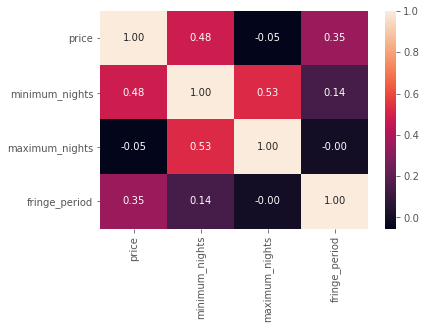

In [29]:
## Output as visualisation:
sns.heatmap(corr_matrix, annot=True, fmt=".2f");

Highest correlation with minimum number of nights. Look more closely at correlation between the dummy fringe variable and the average price:

In [30]:
# sns.jointplot(data=diff_calendar_ave.dropna(), x='fringe_period', y='price', kind="reg", ci=None)

c:\dev\.conda\envs\jupyter-lab\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


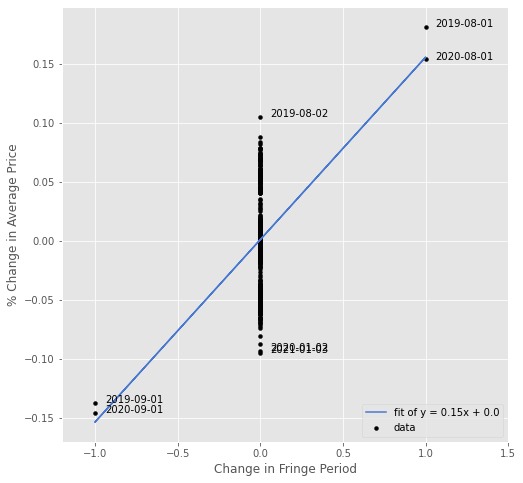

In [31]:
# print(plt.style.available)
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Change in Fringe Period',fontsize=12)
ax.set_ylabel('% Change in Average Price',fontsize=12)

scatter_data = diff_calendar_ave.dropna()
x_var = 'fringe_period'
y_var = 'price'

y_min = 0.09
x_max = 1.2

ax.scatter(scatter_data[x_var],scatter_data[y_var],color='black',s=15, label='data')
ax.set_xlim([-1.2,1.5])

coefficients = np.polyfit(scatter_data[x_var],scatter_data[y_var], deg=1)
fit=np.poly1d(coefficients)
# ax.plot(fit)
ax.plot(scatter_data[x_var], fit(scatter_data[x_var]), label=f'fit of y = {round(coefficients[0], 2)}x + {round(coefficients[1], 2)}')
ax.legend(loc='lower right')

highval_dates = scatter_data[np.abs(scatter_data[y_var])>y_min][np.abs(scatter_data[x_var])<=x_max].index
#     print(highval_dates)
for i in highval_dates:
    plt.annotate(i.strftime('%Y-%m-%d'), # this is the text
                 (scatter_data.loc[i,x_var],scatter_data.loc[i,y_var]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,0), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center

Here we can see that the most extreme outliers in change in price are accounted for by the Fringe festival, which takes place (mainly) in August. Judging by the linear fit, you could expect to charge around 15% more per night during the fringe festival.

We can also see that the next most extreme outliers in change in price are accounted for by the new year (Hogmany), as well as early August - which is festival time. Clearly, if you wish to make the most money but can only rent out your house once a year, choose August rather than new year to do so!

## 3. Question 2: What other factors are important?
What type of property charges the most, and where is it located? Is the optimum location different for different kinds of properties?

### 3.1 Prepare dataset of calendar information and listing information

In [32]:
## Take pre-covid only:----------------------------------------------------------------------------------
calendardf2 = calendardf[calendardf.index <= '2021-05-01']

In [33]:
## Group both datasets together by listing id:-----------------------------------------------------------

## Calendar data:----------------------------------------------------------------------------------------

## Set index
calendardf2 = calendardf2.set_index('listing_id').sort_index()

## Group to listing level:
calendar_ave2 = calendardf2.groupby(calendardf2.index)['price','minimum_nights','maximum_nights'].mean()
# calendar_ave2.head(5)
# calendar_ave2.isnull().sum()

## Listing data:-----------------------------------------------------------------------------------------

## sort index to match for join:
listingsdf.rename(columns = {'id':'listing_id'}, inplace = True)
listingsdf = listingsdf.set_index('listing_id').sort_index()

## Fill missing numeric data with 0s:
listingsdf[['bathrooms','bedrooms','beds']] = listingsdf[['bathrooms','bedrooms','beds']].fillna(0)

## Group to listing level, numeric columns should all be the same, take max to avoid 0s:
listings_ave = listingsdf.groupby(listingsdf.index)['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds'].max()
# listings_ave.head(5)
# listings_ave.isnull().sum()

## Join together:----------------------------------------------------------------------------------------

all_features = listings_ave.join(calendar_ave2, how='inner')
# all_features.head(5)
# all_features.info()
# all_features.isnull().sum()

c:\dev\.conda\envs\jupyter-lab\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':
c:\dev\.conda\envs\jupyter-lab\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


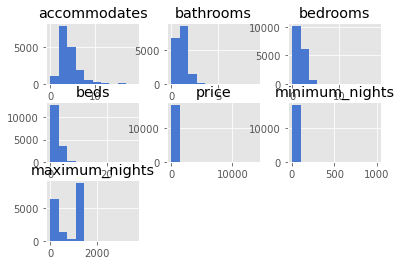

In [34]:
all_features.hist();

In [35]:
## Checks
# for col in all_features.columns:
#     print(f'{col} ranges from {min(all_features[col])} to {max(all_features[col])}')

## Some very high prices
# all_features[all_features['price']==13833.06329113924] # listing id = 40104817
# all_features[all_features['price']==13287.6230248307] # listing id = 21837493

## check starting table:
# listingsdf[listingsdf.index==21837493]
# calendardf[calendardf['listing_id']==40104817]

## If dropped, is it the only outlier?
# all_features = all_features[all_features.index != 40104817]
## no

## These are real property, (though in the first case it doesn't seem to ever have been rented - response rate 0%, no reviews)
## Despite seemingly outlier price, there are others that are also very expensive - they will be kept in

## Also some very high min/max nights:
# all_features[all_features['minimum_nights']==1000.0] # listing id = 5508519 - can't find this one
# all_features[all_features['maximum_nights']==3600.0] # listing id = 3686202 - this one is never available
# listingsdf[listingsdf.index==3686202]
# calendardf[calendardf['listing_id']==3686202]

In [36]:
all_features.head(5)

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights
listing_id,,,,,,,,,,
15420,"Old Town, Princes Street and Leith Street",Entire apartment,Entire home/apt,2,0.0,1.0,1.0,103.375185,2.963072,30.000000
24288,"Canongate, Southside and Dumbiedykes",Loft,Entire home/apt,4,1.5,2.0,2.0,101.882440,2.000000,777.797619
38628,Joppa,Entire apartment,Entire home/apt,2,0.0,1.0,0.0,51.494083,4.091716,641.338757
44009,Marchmont East and Sciennes,Private room in apartment,Private room,2,0.0,1.0,1.0,45.000000,2.000000,10.000000
44552,South Leith,Private room in condominium,Private room,2,0.0,1.0,1.0,32.137371,1.454948,21.000000


In [37]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16756 entries, 15420 to 48536660
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  16756 non-null  object 
 1   property_type           16756 non-null  object 
 2   room_type               16756 non-null  object 
 3   accommodates            16756 non-null  int64  
 4   bathrooms               16756 non-null  float64
 5   bedrooms                16756 non-null  float64
 6   beds                    16756 non-null  float64
 7   price                   16756 non-null  float64
 8   minimum_nights          16756 non-null  float64
 9   maximum_nights          16756 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.9+ MB


In [38]:
all_features.isnull().sum()

neighbourhood_cleansed    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
price                     0
minimum_nights            0
maximum_nights            0
dtype: int64

Accommodates seems to be most highly correlated - as expected - though low values for correlation could be explained by non-linear relationships. Investigate these using GBM and partial dependence plots.

### 3.2 Prepare categorical variables

In [39]:
## Get number of unique values for each categorical column:----------------------------------------------

cat_cols = all_features.select_dtypes(include=['object']).copy()
cat_list = []
for col in cat_cols.columns:
    cat_list.append(col)
    print(f'{col} has {len(all_features[col].unique())} unique entries')
print(f'number of observations in dataset = {all_features.shape[0]}')

neighbourhood_cleansed has 111 unique entries
property_type has 72 unique entries
room_type has 4 unique entries
number of observations in dataset = 16756


This will produce a lot of dummy columns - could potentially be too many columns given the number of observations

In [40]:
## Get dummies for categorical features:-----------------------------------------------------------------

all_features_dummies = pd.get_dummies(all_features, prefix=cat_list)
all_features_dummies.head(5)

print(f'number of columns = {all_features_dummies.shape[1]}')

number of columns = 194


Still have way more rows than columns - should be OK

### 3.3 Output correlation

In [41]:
## Too many columns to output as table or heatmap. Pull top 10 instead-----------------------------------

## First split predictor cols from target (price):-------------------------------------------------------
df = all_features_dummies.loc[ : , all_features_dummies.columns != 'price']
predictor_cols = []
for col in df.columns:
    predictor_cols.append(col)
# predictor_cols

## Check correlation with price:-------------------------------------------------------------------------

## Create empty df
df_corr = pd.DataFrame(index=predictor_cols, columns=(['price'])) 
df_corr.head(5)
df_corr.columns

## Populate dataframe with correlation
corr_matrix = all_features_dummies.corr()
df_corr['price']=corr_matrix['price']

## Get absolute values
df_corr['price_abs']=abs(corr_matrix['price'])

In [42]:
## Display top features
df_corr.sort_values('price_abs',ascending=False).head(20)

,price,price_abs
accommodates,0.197514,0.197514
bedrooms,0.162463,0.162463
beds,0.159415,0.159415
room_type_Private room,-0.114583,0.114583
room_type_Entire home/apt,0.106812,0.106812
property_type_Room in serviced apartment,0.059296,0.059296
property_type_Hostel,0.056728,0.056728
bathrooms,0.056198,0.056198
neighbourhood_cleansed_Deans Village,0.048863,0.048863
neighbourhood_cleansed_Leith (Albert Street),0.048389,0.048389


Accommodates, bedrooms and beds seem to be most highly correlated - as could be expected - though low values for correlation could be explained by non-linear relationships. Could investigate these using GBM and partial dependence plots. <br>
Private rooms/entire home etc seem to be correlated to higher price. <br>
Dean's Village seems to be a pricy area to rent - this is where the outlier found earlier was, could be due to that. <br>

## 4. Question 3: How much should you charge?
With all that we now know, can we predict price based on property details?

### 4.1 Ordinary Least Squares

In [52]:
## Train model:------------------------------------------------------------------------------------------

#Split into explanatory and response variables
X = sm.add_constant(all_features_dummies[predictor_cols])
# X = all_features_dummies[predictor_cols]
y = all_features_dummies['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

model = sm.OLS(y_train, X_train).fit()
       
## Predict and score the model:--------------------------------------------------------------------------
#Predict and score the model
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test) 
print(f'The training r-squared score for the model was {r2_score(y_train, y_train_preds)} on {len(y_train)} values.')
print(f'The test r-squared score for the model was {r2_score(y_test, y_test_preds)} on {len(y_test)} values.')

print(f'The average price in train is {np.mean(y_train)}')
print(f'The MAE in train is {np.mean(np.abs(y_train - y_train_preds))}')
print(f'The average price in test is {np.mean(y_test)}')
print(f'The MAE in test is {np.mean(np.abs(y_test - y_test_preds))}')

The training r-squared score for the model was 0.06720115684674177 on 11729 values.
The test r-squared score for the model was 0.051572152097446144 on 5027 values.
The average price in train is 129.0548173830727
The MAE in train is 81.73783862650141
The average price in test is 120.83739430486824
The MAE in test is 77.99976049413549


MAE is high, though train and test perform similarly suggesting overfitting not a large problem. <br>
Try regularisation to see if it improves

In [53]:
## Test on my own house:

## Create a dataframe of details of my own house, and populate it as if I was to rent it out
my_features = pd.DataFrame(data=np.zeros((1, len(predictor_cols)+1)), index=[1], columns=[['const']+predictor_cols])

# all_features['neighbourhood_cleansed'].unique()
# all_features['property_type'].unique()
# all_features['room_type'].unique()

my_features['const'] = 1.0
my_features['neighbourhood_cleansed_Dalry and Fountainbridge'] = 1
my_features['property_type_Private room in house'] = 1
my_features['room_type_Private room'] =1
my_features['accommodates'] = 2
my_features['bathrooms'] = 1
my_features['bedrooms'] = 1.0
my_features['beds'] = 1.0
my_features['minimum_nights'] = 2.0
my_features['maximum_nights'] = 5.0


# my_features.head()

print(f'OLS model predicts I should charge ${round(model.predict(my_features)[1], 2)} per night')

OLS model predicts I should charge $193.9 per night


### 4.2 Ridge Regression

In [54]:
model = Ridge(fit_intercept=True, normalize=True) 

param_search = {'alpha' : np.logspace(-4, 0, num=100, dtype=float)}

gsearch = GridSearchCV(estimator=model, param_grid=param_search,scoring='neg_mean_absolute_error',cv=5)
gsearch.fit(X_train, y_train)

## print best alpha:
# print(f'{gsearch.best_params_['alpha']}')

model = gsearch.best_estimator_
model.fit(X_train, y_train)

#Predict and score the model
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test) 
print("The r-squared score for the model on train set was {} on {} values.".format(r2_score(y_train, y_train_preds), len(y_train)))
print("The r-squared score for the model on test set was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))

print(f'The average price in train is {np.mean(y_train)}')
print(f'The MAE in train is {np.mean(np.abs(y_train - y_train_preds))}')
print(f'The average price in test is {np.mean(y_test)}')
print(f'The MAE in test is {np.mean(np.abs(y_test - y_test_preds))}')

The r-squared score for the model on train set was 0.053858918649687615 on 11729 values.
The r-squared score for the model on test set was 0.05341836227344965 on 5027 values.
The average price in train is 129.0548173830727
The MAE in train is 72.87880297034172
The average price in test is 120.83739430486824
The MAE in test is 68.03041500520787


Not a fantastic model but marginally better than previous. If I had more time I would look into engineering better features/including more

In [55]:
## Test on a room in my own house:

my_features['const'] = 1.0
my_features['neighbourhood_cleansed_Dalry and Fountainbridge'] = 1
my_features['property_type_Private room in house'] = 1
my_features['room_type_Private room'] =1
my_features['accommodates'] = 2
my_features['bathrooms'] = 1
my_features['bedrooms'] = 1.0
my_features['beds'] = 1.0
my_features['minimum_nights'] = 2.0
my_features['maximum_nights'] = 5.0

print(f'Ridge model predicts I should charge ${round(model.predict(my_features)[0], 2)} per night')

Ridge model predicts I should charge $106.33 per night


Looking at the Airbnb website, houses near me charge from around £50 to around £100 per night, so potentially not bad. May need to include more details like ensuite, parking, wifi etc.

In [56]:
## How much more if I had an additional bathroom?
my_features['bathrooms'] = 2
print(f'Ridge model predicts I should charge ${round(model.predict(my_features)[0], 2)} per night with 2 bathrooms')

## How much more if I rented out the whole house?
my_features['bathrooms'] = 1
my_features['bedrooms'] = 3.0
my_features['beds'] = 3.0
my_features['property_type_Entire townhouse'] = 1
my_features['room_type_Entire home/apt'] =1
my_features['accommodates'] = 6
print(f'Ridge model predicts I should charge ${round(model.predict(my_features)[0], 2)} per night for the entire house')

Ridge model predicts I should charge $122.1 per night with 2 bathrooms
Ridge model predicts I should charge $241.36 per night for the entire house


# Evaluation
* OLS predicts £137.75, which seems high when looking at listings available nearby. Ridge regression performs better.
* Although lower than OLS, given the high test set MAE compared to predictions and average price in the datasets, the Ridge model is not optimal, but a lot more time and would would be required to engineer features, scrape more data from the data source to produce more features, and test out different modelling approaches to improve performance.

# Deployment
* Use the pre-trained model to make custom predictions

### 4.3 Put in your own details

In [59]:
## View the options of inputs:
all_features['neighbourhood_cleansed'].unique()

array(['Old Town, Princes Street and Leith Street',
       'Canongate, Southside and Dumbiedykes', 'Joppa',
       'Marchmont East and Sciennes', 'South Leith', 'New Town West',
       'Dalry and Fountainbridge', 'Hillside and Calton Hill',
       'Deans Village', 'New Town East and Gayfield',
       'North Leith and Newhaven', 'Leith (Albert Street)',
       "Siverknowes and Davidson's Mains", 'Merchiston and Greenhill',
       'Meadowbank and Abbeyhill North', 'Meadows and Southside',
       'Leith (Hermitage and Prospect Bank)',
       'Jewel, Brunstane and Newcraighall',
       'The Shore and Constitution Street',
       'Easter Road and Hawkhill Avenue', 'Tollcross',
       'Murrayfield and Ravelston', 'Newington and Dalkeith Road',
       'Drylaw', 'Broughton South', 'Bonnington', 'Marchmont West',
       'Broughton North and Powderhall', 'Oxgangs', 'Portobello',
       'Bruntsfield', 'Comiston and Swanston',
       'Willowbrae and Duddingston Village', 'Shandon', 'Corstorphine',

In [60]:
all_features['property_type'].unique()

array(['Entire apartment', 'Loft', 'Private room in apartment',
       'Private room in condominium', 'Condominium', 'Apartment', 'Boat',
       'Entire loft', 'House', 'Private room in bed and breakfast',
       'Private room in house', 'Entire condominium', 'Bed and breakfast',
       'Private room in guesthouse', 'Room in boutique hotel',
       'Entire townhouse', 'Entire villa', 'Private room in townhouse',
       'Private room in guest suite', 'Entire house',
       'Entire serviced apartment', 'Room in serviced apartment',
       'Townhouse', 'Private room in bungalow', 'Cottage',
       'Entire guest suite', 'Entire cottage', 'Villa', 'Other',
       'Serviced apartment', 'Bungalow', 'Entire guesthouse',
       'Boutique hotel', 'Hostel', 'Shared room in hostel',
       'Private room in cottage', 'Camper/RV', 'Guesthouse', 'Campsite',
       'Private room in tent', 'Tent', 'Guest suite', 'Private room',
       'Room in hostel', 'Entire bungalow', 'Room in hotel', 'Hut',
       

In [61]:
all_features['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [62]:
## Set feature values accordingly:
my_features['const'] = 1.0
my_features['neighbourhood_cleansed_Dalry and Fountainbridge'] = 1
my_features['property_type_Private room in house'] = 1
my_features['room_type_Shared room'] =1
my_features['accommodates'] = 2
my_features['bathrooms'] = 1
my_features['bedrooms'] = 1.0
my_features['beds'] = 1.0
my_features['minimum_nights'] = 2.0
my_features['maximum_nights'] = 5.0

## Print prediction:
print(f'Custom Ridge model prediction = ${round(model.predict(my_features)[0], 2)} per night')

Custom Ridge model prediction = $137.47 per night


## Appendix: Other things to look into:
* Group together some categories in categorical variables for simplified, more general features, and fewer of them. For example, whole property or not whole property rather than all of the different options
* Re-do but taking into account availabilty - does training only on data where the let was booked change the price recommended?
* What type of property charges the most, and where is it located? Is the optimum location different for different kinds of properties?
* How exactly has all of this changed post-covid?
* Look more closely at the very long-term rents and very expensive lets
* Compare regression approach with e.g. KNN/Kmeans to predict how much should you charge based on area alone